## Lectura 7-2: Predictores categóricos e interacciones




Hasta ahora, en cada uno de nuestros análisis, sólo hemos utilizado variables numéricas como predictores. También hemos utilizado únicamente *modelos aditivos*, lo que significa que el efecto que cualquier predictor tenía sobre la respuesta no dependía de los otros predictores. En este capítulo, eliminaremos estas dos restricciones. Ajustaremos modelos con predictores categóricos y utilizaremos modelos que permiten que los predictores *interactúen*. Las matemáticas de la regresión múltiple permanecerán en gran medida inalteradas, sin embargo, prestaremos mucha atención a la interpretación, así como a algunas diferencias en el uso en `python`.



## Variables ficticias

En este capítulo, utilizaremos brevemente el conjunto de datos incorporado `mtcars` antes de volver a nuestro conjunto de datos `autompg` que usamos en la lectura anterior. El conjunto de datos `mtcars` es algo más pequeño, por lo que echaremos un vistazo rápidamente a todo el conjunto de datos.


In [78]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import matplotlib.pyplot as plt


# Please note that you need to install openpyxl to read .xlsx files

# Read the .xlsx file
mtcars = pd.read_excel('../data/mtcars.xlsx', engine='openpyxl')

# Display the dataframe
print(mtcars)



     mpg  cyl   disp   hp  drat     wt   qsec  vs  am  gear  carb
0   21.0    6  160.0  110  3.90  2.620  16.46   0   1     4     4
1   21.0    6  160.0  110  3.90  2.875  17.02   0   1     4     4
2   22.8    4  108.0   93  3.85  2.320  18.61   1   1     4     1
3   21.4    6  258.0  110  3.08  3.215  19.44   1   0     3     1
4   18.7    8  360.0  175  3.15  3.440  17.02   0   0     3     2
5   18.1    6  225.0  105  2.76  3.460  20.22   1   0     3     1
6   14.3    8  360.0  245  3.21  3.570  15.84   0   0     3     4
7   24.4    4  146.7   62  3.69  3.190  20.00   1   0     4     2
8   22.8    4  140.8   95  3.92  3.150  22.90   1   0     4     2
9   19.2    6  167.6  123  3.92  3.440  18.30   1   0     4     4
10  17.8    6  167.6  123  3.92  3.440  18.90   1   0     4     4
11  16.4    8  275.8  180  3.07  4.070  17.40   0   0     3     3
12  17.3    8  275.8  180  3.07  3.730  17.60   0   0     3     3
13  15.2    8  275.8  180  3.07  3.780  18.00   0   0     3     3
14  10.4  


Nos interesarán tres de las variables: `mpg`, `hp` y `am`.

- `mpg`: eficiencia del combustible, en millas por galón.
- `hp`: caballos de fuerza, en libras-pie por segundo.
- `am`: transmisión. Automática o manual.

Como hacemos a menudo, vamos a empezar por trazar los datos. Estamos interesados en `mpg` como variable de respuesta, y `hp` como predictor.

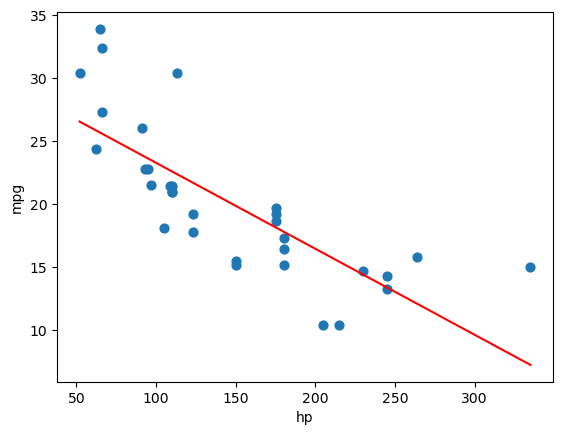

In [79]:
# First plot
plt.scatter(mtcars['hp'], mtcars['mpg'], s=20*2)
#include line of best fit
plt.plot(np.unique(mtcars['hp']), np.poly1d(np.polyfit(mtcars['hp'], mtcars['mpg'], 1))(np.unique(mtcars['hp'])), color='red')
plt.xlabel('hp')
plt.ylabel('mpg')
plt.show()


Como también nos interesa el tipo de transmisión, también podríamos etiquetar los puntos en consecuencia.


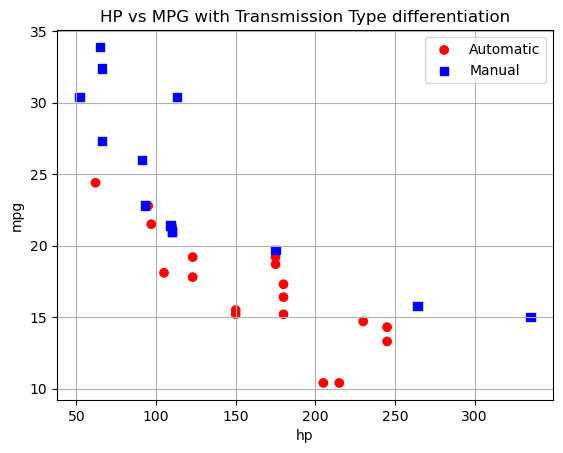

In [80]:
# Colors and markers based on 'am'
colors = mtcars['am'].apply(lambda x: 'red' if x == 0 else 'blue')
markers = mtcars['am'].apply(lambda x: 'o' if x == 0 else 's')

# Scatter plot
for i, marker in enumerate(['o', 's']):
    subset = mtcars[mtcars['am'] == i]
    plt.scatter(subset['hp'], subset['mpg'], color=colors[subset.index], marker=marker, label='Automatic' if i == 0 else 'Manual')

# Line of best fit
X = mtcars['hp'].values.reshape(-1, 1)
y = mtcars['mpg'].values


# Additional configurations
plt.legend()
plt.xlabel('hp')
plt.ylabel('mpg')
plt.title('HP vs MPG with Transmission Type differentiation')
plt.grid(True)
plt.show()



Ahora ajustamos el modelo SLR

$$ Y = \beta_0 + \beta_1 x_1 + \epsilon, $$ 

donde $Y$ es `mpg` y $x_1$ es `hp`. Por brevedad, suprimimos el índice $i$ para las observaciones.


In [81]:
# Linear regression
model = sm.OLS(mtcars['mpg'], sm.add_constant(mtcars[['hp']]))
mpg_hp_slr = model.fit()

A continuación, volvemos a representar los datos y añadimos la línea ajustada al gráfico.

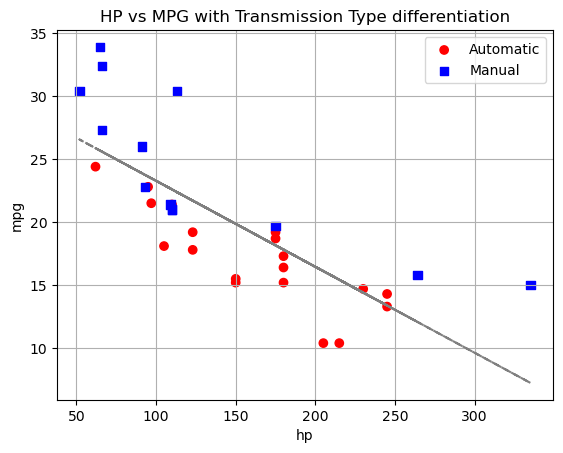

In [82]:

# Colors and markers based on 'am'
colors = mtcars['am'].apply(lambda x: 'red' if x == 0 else 'blue')
markers = mtcars['am'].apply(lambda x: 'o' if x == 0 else 's')

# Scatter plot
for i, marker in enumerate(['o', 's']):
    subset = mtcars[mtcars['am'] == i]
    plt.scatter(subset['hp'], subset['mpg'], color=colors[subset.index], marker=marker, label='Automatic' if i == 0 else 'Manual')

# Line of best fit
X_for_prediction = sm.add_constant(mtcars[['hp']])
plt.plot(mtcars['hp'], mpg_hp_slr.predict(X_for_prediction), color='gray', linestyle='--')

# Additional configurations
plt.legend()
plt.xlabel('hp')
plt.ylabel('mpg')
plt.title('HP vs MPG with Transmission Type differentiation')
plt.grid(True)
plt.show()


Deberíamos notar un patrón aquí. Las observaciones manuales azules se sitúan en gran medida por encima de la línea, mientras que las observaciones automáticas rojas se sitúan en su mayoría por debajo de la línea. Esto significa que nuestro modelo subestima la eficiencia de combustible de las transmisiones manuales, y sobreestima la eficiencia de combustible de las transmisiones automáticas. Para corregir esto, vamos a añadir un predictor a nuestro modelo, a saber, `am` como $x_2$.

Nuestro nuevo modelo es

$$ Y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \epsilon, $$ 

donde $x_1$ y $Y$ siguen siendo los mismos, pero ahora

$$ 
x_2 =
  \begin{cases}
   1 & \text{manual transmission} \\
   0       & \text{automatic transmission}
  \end{cases}.
$$ 

En este caso, llamamos a $x_2$ una **variable dummy**. Una variable dummy (o ficticia) tiene un nombre un tanto desafortunado, ya que no es en absoluto "tonta". De hecho, es algo inteligente. Una variable de este tipo es una variable numérica que se utiliza en un análisis de regresión para "codificar" una variable categórica binaria. Veamos cómo funciona.

- En primer lugar, observe que `am` ya es una variable ficticia, puesto que utiliza los valores `0` y `1` para representar las transmisiones automática y manual. A menudo, una variable como `am` almacenaría los valores de carácter `auto` y `man` y tendríamos que convertirlos a `0` y `1` o, como veremos más adelante, `Python` se encargará de crear variables ficticias por nosotros.

Así que, para ajustar el modelo anterior, lo hacemos como cualquier otro modelo de regresión múltiple que hayamos visto antes.


In [83]:
import statsmodels.formula.api as smf

# Regression
mpg_hp_add = smf.ols('mpg ~ hp + am', data=mtcars).fit()
print(mpg_hp_add.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     52.02
Date:                Tue, 19 Sep 2023   Prob (F-statistic):           2.55e-10
Time:                        21:35:40   Log-Likelihood:                -78.003
No. Observations:                  32   AIC:                             162.0
Df Residuals:                      29   BIC:                             166.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     26.5849      1.425     18.655      0.0


Comprobando brevemente la salida, vemos que `Python` ha estimado los tres parámetros $\beta$.


In [84]:
mpg_hp_add.params

Intercept    26.584914
hp           -0.058888
am            5.277085
dtype: float64


Dado que $x_2$ sólo puede tomar valores `0` y `1`, podemos escribir efectivamente dos modelos diferentes, uno para transmisiones manuales y otro para transmisiones automáticas.

Para transmisiones automáticas, es decir $x_2 = 0$, tenemos,

$$ Y = \beta_0 + \beta_1 x_1 + \epsilon. $$

Entonces para transmisiones manuales, es decir $x_2 = 1$, tenemos,

$$ Y = (\beta_0 + \beta_2) + \beta_1 x_1 + \epsilon. $$ 

Observe que estos modelos comparten la misma pendiente, $\beta_1$, pero tienen diferentes interceptos, que difieren en $\beta_2$. Así que el cambio en `mpg` es el mismo para ambos modelos, pero en promedio `mpg` difiere en $\beta_2$ entre los dos tipos de transmisión.

Ahora vamos a calcular la pendiente estimada y el intercepto de estos dos modelos para que podamos añadirlos a un gráfico. Tenga en cuenta que:

-   $\hat{\beta}_0$ = `26.584914`
-   $\hat{\beta}_1$ = ` -0.05888`
-   $\hat{\beta}_2$ = ` 5.277085`

A continuación, podemos combinarlos para calcular la pendiente y los interceptos estimados.


In [85]:
# Extract coefficients
int_auto = mpg_hp_add.params['Intercept']
int_manu = mpg_hp_add.params['Intercept'] + mpg_hp_add.params['am']

print(int_auto)
print(int_manu)

26.584913747970575
31.861999056149198


In [86]:
slope_auto = mpg_hp_add.params['hp']
slope_manu = mpg_hp_add.params['hp']

print(slope_auto)
print(slope_manu)

-0.05888780335351099
-0.05888780335351099



Al volver a representar los datos, utilizamos estas pendientes e interceptos para añadir los "dos" modelos ajustados al gráfico.

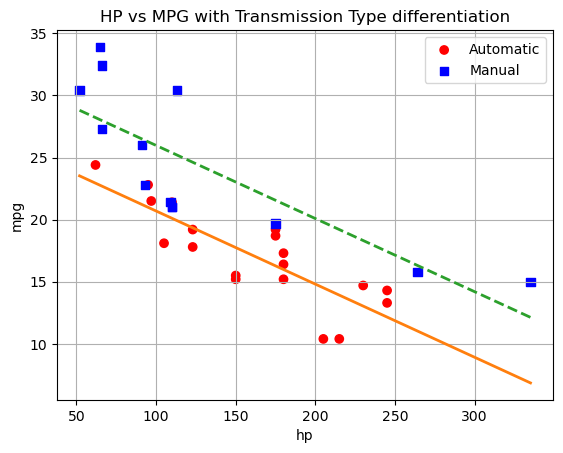

In [87]:

# Colors and markers based on 'am'
colors = mtcars['am'].apply(lambda x: 'red' if x == 0 else 'blue')
markers = mtcars['am'].apply(lambda x: 'o' if x == 0 else 's')

# Scatter plot
for i, marker in enumerate(['o', 's']):
    subset = mtcars[mtcars['am'] == i]
    plt.scatter(subset['hp'], subset['mpg'], color=colors[subset.index], marker=marker, label='Automatic' if i == 0 else 'Manual')

# Add regression lines
x = np.linspace(min(mtcars['hp']), max(mtcars['hp']), 100)
plt.plot(x, int_auto + slope_auto * x, color='C1', linestyle='-', linewidth=2)
plt.plot(x, int_manu + slope_manu * x, color='C2', linestyle='--', linewidth=2)

# Additional configurations
plt.legend()
plt.xlabel('hp')
plt.ylabel('mpg')
plt.title('HP vs MPG with Transmission Type differentiation')
plt.grid(True)
plt.show()

Observamos enseguida que los puntos ya no son sistemáticamente incorrectos. Las observaciones rojas, manuales, varían en torno a la línea roja sin ningún patrón particular, sin subestimar las observaciones como antes. Los puntos negros, automáticos, varían en torno a la línea negra, también sin un patrón evidente.

Dicen que una imagen vale más que mil palabras, pero como estadístico, a veces una imagen vale más que todo un análisis. La imagen anterior hace claramente obvio que $\beta_2$ es significativo, pero vamos a verificar matemáticamente. Esencialmente nos gustaría probar:

$$
H_0: \beta_2 = 0 \quad \text{vs} \quad H_1: \beta_2 \neq 0.
$$ 

Esto no es nada nuevo. De nuevo, las matemáticas son las mismas que las de los análisis de regresión múltiple que hemos visto antes. Podríamos realizar aquí una prueba $t$ o $F$. La única diferencia es un ligero cambio en la interpretación. Podríamos pensar en esto como una prueba de un modelo con una sola línea ($H_0$) contra un modelo que permite dos líneas ($H_1$).

Para obtener el estadístico de prueba y el valor p para la prueba $t$, utilizaríamos

In [88]:
# Extract the 'am' coefficient details from the summary
summary_df = pd.DataFrame(mpg_hp_add.summary().tables[1].data[1:], columns=mpg_hp_add.summary().tables[1].data[0])
am_coeff = summary_df[summary_df[''] == 'am']
print(am_coeff)


             coef    std err          t   P>|t|     [0.025     0.975]
2  am      5.2771      1.080      4.888   0.000      3.069      7.485



Para hacer lo mismo con la prueba $F$, utilizaríamos


In [89]:
# Perform ANOVA test between the two models
anova_results = sm.stats.anova_lm(mpg_hp_slr, mpg_hp_add, typ=1)

print(anova_results)

   df_resid         ssr  df_diff     ss_diff          F    Pr(>F)
0      30.0  447.674314      0.0         NaN        NaN       NaN
1      29.0  245.439288      1.0  202.235025  23.895179  0.000035



Observe que, en efecto, se trata de la misma prueba, ya que los valores p son exactamente iguales. (Y el estadístico de prueba $F$ es el estadístico de prueba $t$ al cuadrado).

Recapitulando algunas interpretaciones:

-   $\hat{\beta}_0 = 26.58$ es el consumo medio estimado para un coche con transmisión automática y **0** `hp`.

-   $\hat{\beta}_0 + \hat{\beta}_2 = 31.86$  es la media estimada de "mpg" de un coche con transmisión manual
y **0** `hp`.

-   $\hat{\beta}_2 = 5.27$ es la **diferencia** estimada en la media de `mpg` de los carros con transmisión manual respecto a los de transmisión automática, para **cualquier** `hp`.

-   $\hat{\beta}_1 = -0.058$ es el cambio estimado en la media de `mpg` para un aumento de un `hp`, para **cualquiera** de los tipos de transmisión.

Debemos prestar especial atención a los dos últimos. En el modelo,

$$
Y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \epsilon,
$$



Vemos que $\beta_1$ es el cambio medio en $Y$ para un aumento en $x_1$, *sin importar* el valor de $x_2$. Además, $\beta_2$ es siempre la diferencia en la media de $Y$ para *cualquier* valor de $x_1$. Estas son dos restricciones que no siempre vamos a querer, por lo que necesitamos una manera de especificar un modelo más flexible.

Aquí nos limitamos a un único predictor numérico $x_1$ y una variable ficticia $x_2$. Sin embargo, el concepto de variable ficticia puede utilizarse con modelos de regresión múltiple más amplios. Aquí sólo utilizamos un único predictor numérico para facilitar la visualización, ya que podemos pensar en la interpretación de "dos líneas". Pero en general, podemos pensar en una variable ficticia como la creación de "dos modelos", uno para cada categoría de una variable categórica binaria.



## Interacciones

Para eliminar la restricción de la "misma pendiente", hablaremos ahora de **interacción**. Para ilustrar este concepto, volveremos al conjunto de datos `autompg` que creamos en una anterior lectura,  con algunas modificaciones más.


In [90]:
import pandas as pd

# Read data frame from the web
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
autompg = pd.read_csv(url, sep="\s+", header=None, comment="\t", quotechar="\"", na_values=["?"])

# Assign headers to the dataframe
autompg.columns = ["mpg", "cyl", "disp", "hp", "wt", "acc", "year", "origin", "name"]

# Remove rows with missing 'hp' data
autompg = autompg[autompg['hp'].notna()]

# Remove 'plymouth reliant'
autompg = autompg[autompg['name'] != "plymouth reliant"]

# Create row names based on the engine, year, and name
autompg.index = autompg['cyl'].astype(str) + " cylinder " + autompg['year'].astype(str) + " " + autompg['name']

# Drop the 'name' column
autompg.drop('name', axis=1, inplace=True)

# Convert horsepower from object to numeric
autompg['hp'] = pd.to_numeric(autompg['hp'], errors='coerce')

# Create a dummy variable for foreign vs. domestic cars. Domestic = 1.
autompg['domestic'] = (autompg['origin'] == 1).astype(int)

# Remove 3 and 5 cylinder cars
autompg = autompg[~autompg['cyl'].isin([3, 5])]

# Change 'cyl' to a category variable
autompg['cyl'] = autompg['cyl'].astype('category')

# Display the structure (similar to str in R)
print(autompg.info())


<class 'pandas.core.frame.DataFrame'>
Index: 383 entries, 8 cylinder 70 chevrolet chevelle malibu to 4 cylinder 82 chevy s-10
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   mpg       383 non-null    float64 
 1   cyl       383 non-null    category
 2   disp      383 non-null    float64 
 3   hp        383 non-null    float64 
 4   wt        383 non-null    float64 
 5   acc       383 non-null    float64 
 6   year      383 non-null    int64   
 7   origin    383 non-null    int64   
 8   domestic  383 non-null    int32   
dtypes: category(1), float64(5), int32(1), int64(2)
memory usage: 25.9+ KB
None


In [91]:
autompg.head()

,mpg,cyl,disp,hp,wt,acc,year,origin,domestic
8 cylinder 70 chevrolet chevelle malibu,18.0,8,307.0,130.0,3504.0,12.0,70,1,1
8 cylinder 70 buick skylark 320,15.0,8,350.0,165.0,3693.0,11.5,70,1,1
8 cylinder 70 plymouth satellite,18.0,8,318.0,150.0,3436.0,11.0,70,1,1
8 cylinder 70 amc rebel sst,16.0,8,304.0,150.0,3433.0,12.0,70,1,1
8 cylinder 70 ford torino,17.0,8,302.0,140.0,3449.0,10.5,70,1,1



Hemos eliminado los carros con `3` y `5` cilindros, así como creado una nueva variable `domestic` que indica si un coche fue fabricado o no en Estados Unidos. La eliminación de los cilindros `3` y `5` es simplemente para facilitar la demostración más adelante en la lectura y no se haría en la práctica. La nueva variable `domestic` toma el valor `1` si el coche fue construido en Estados Unidos, y `0` en caso contrario, a lo que nos referiremos como "extranjero". (También hemos convertido `cyl` y `origin` en variables factoriales, de las que hablaremos más adelante.

Ahora nos ocuparemos de tres variables: `mpg`, `disp` y `doméstico`. Utilizaremos `mpg` como respuesta. Podemos ajustar un modelo,


$$ 
Y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \epsilon,
$$

donde

-   $Y$ es `mpg`, la eficiencia del combustible en millas por galón,
-   $x_1$ es `disp`,la cilindrada en pulgadas cúbicas,
-   $x_2$ es `domestic` como se ha descrito anteriormente, que es una variable ficticia.

$$
x_2 =
  \begin{cases}
   1 & \text{Domestic} \\
   0 & \text{Foreign}
  \end{cases}
$$

Ajustaremos este modelo, extraeremos la pendiente y la intersección de las "dos rectas", representaremos los datos y sumaremos las rectas.


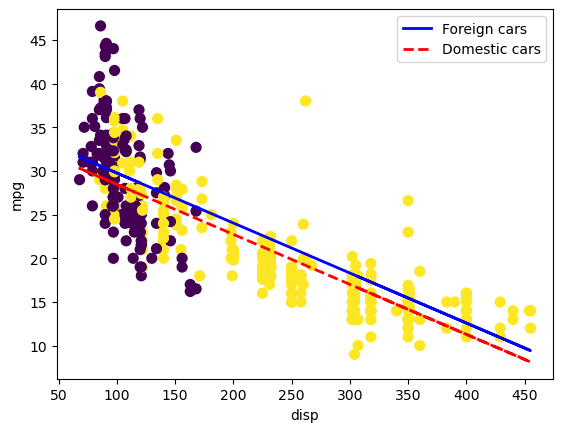

In [92]:

# Assuming 'autompg' dataframe is already loaded as in the previous conversion.

# Fit linear regression model
X = autompg[['disp', 'domestic']]
X = sm.add_constant(X)  # Add a constant for the intercept
mpg_disp_add= sm.OLS(autompg['mpg'], X).fit()

# Get coefficients
int_for = mpg_disp_add.params['const']
int_dom = mpg_disp_add.params['const'] + mpg_disp_add.params['domestic']
slope_for = mpg_disp_add.params['disp']
slope_dom = mpg_disp_add .params['disp']

# Plotting
colors = autompg['domestic'] + 1
plt.scatter(autompg['disp'], autompg['mpg'], c=colors, marker='o', s=50, cmap='viridis')
plt.xlabel('disp')
plt.ylabel('mpg')

# Adding regression lines
x_vals = autompg['disp'].values
plt.plot(x_vals, int_for + slope_for * x_vals, color='blue', linewidth=2, label='Foreign cars')
plt.plot(x_vals, int_dom + slope_dom * x_vals, color='red', linestyle='--', linewidth=2, label='Domestic cars')

# Adding legend
plt.legend(loc='upper right')
plt.show()



Se trata de un modelo que tiene en cuenta dos líneas *paralelas*, lo que significa que los `mpg` pueden ser diferentes de media entre carros extranjeros y nacionales de la misma cilindrada, pero el cambio en los `mpg` medios para un aumento de la cilindrada es el mismo para ambos. Podemos ver que este modelo no funciona muy bien aquí. La línea roja se ajusta bastante bien a los puntos amarillos, pero la línea azul no lo hace muy bien para los puntos violeta, debería tener claramente una pendiente más negativa. Esencialmente, nos gustaría un modelo que permita dos pendientes diferentes.

Consideremos el siguiente modelo,

$$ 
Y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_1 x_2 + \epsilon,
$$

donde $x_1$, $x_2$, y $Y$ son los mismos que antes, pero hemos añadido un nuevo término de **interacción** $x_1 x_2$ que multiplica $x_1$ y $x_2$, por lo que también tenemos un parámetro $\beta$ adicional $\beta_3.$

Este modelo crea esencialmente dos pendientes y dos interceptos, siendo $\beta_2$ la diferencia en interceptos y $\beta_3$ la diferencia en pendientes. Para ver esto, vamos a desglosar el modelo en los dos "submodelos" para los carros extranjeros y nacionales.

Para los carros extranjeros, es decir $x_2 = 0$, tenemos

$$
Y = \beta_0 + \beta_1 x_1 + \epsilon.
$$

Para los carros nacionales, es decir $x_2 = 1$, tenemos

$$
Y = (\beta_0 + \beta_2) + (\beta_1 + \beta_3) x_1 + \epsilon.
$$


Estos dos modelos tienen pendientes e interceptos diferentes.

-   $\beta_0$ es la media de `mpg` de un coche extranjero con **0** `disp`.
-   $\beta_1$ es el cambio en la media de `mpg` para un aumento de un `disp`, para carros **extranjeros**.
-   $\beta_0 + \beta_2$ es la media de `mpg` de un coche nacional con
    **0** `disp`.
-   $\beta_1 + \beta_3$ es el cambio en la media de `mpg` para un aumento de un `disp`, para carros **domésticos**.

¿Cómo ajustamos este modelo en `Python`? Hay varias formas de hacerlo.

Un método sería simplemente crear una nueva variable, y luego ajustar un modelo como cualquier otro.


In [93]:
# Create interaction term
autompg['x3'] = autompg['disp'] * autompg['domestic']



Sólo debe hacerlo como último recurso. Preferimos no tener que modificar nuestros datos simplemente para ajustar un modelo. En su lugar, podemos decirle a `Python` que nos gustaría utilizar los datos existentes con un término de interacción.


In [94]:
# Interaction term (though we don't really need to create it manually with the formula API)
autompg['x3'] = autompg['disp'] * autompg['domestic']

# Fit linear regression models
model_int = smf.ols('mpg ~ disp + domestic + x3', data=autompg).fit()


Un método alternativo, que se ajustará exactamente al mismo modelo que el anterior, sería utilizar el operador `*`. Este método crea automáticamente el término de interacción, así como cualquier "término de orden inferior", que en este caso son los términos de primer orden para `disp` y `domestic`.


In [95]:
model_int2 = smf.ols('mpg ~ disp * domestic', data=autompg).fit()  # Equivalent to the previous model



Podemos comprobar rápidamente que hacen lo mismo.


In [96]:
# Print coefficients
print(model_int.params)
print(model_int2.params)

Intercept    46.054842
disp         -0.156924
domestic    -12.575471
x3            0.102518
dtype: float64
Intercept        46.054842
disp             -0.156924
domestic        -12.575471
disp:domestic     0.102518
dtype: float64



Vemos que tanto las variables como las estimaciones de sus coeficientes son efectivamente las mismas para ambos modelos.


In [97]:
# Print summary for model_int
print(model_int2.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     296.3
Date:                Tue, 19 Sep 2023   Prob (F-statistic):           5.41e-99
Time:                        21:35:41   Log-Likelihood:                -1100.8
No. Observations:                 383   AIC:                             2210.
Df Residuals:                     379   BIC:                             2225.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        46.0548      1.806     25.504


Vemos que utilizando `summary()` se obtienen los resultados habituales de un modelo de regresión múltiple. Prestamos mucha atención a la fila para `disp:domestic` que prueba,

$$
H_0: \beta_3 = 0.
$$

En este caso, la prueba de $\beta_3 = 0$ es la prueba de dos líneas con pendientes paralelas frente a dos líneas con pendientes posiblemente diferentes. La línea `disp:domestic` en la salida `summary()` utiliza una prueba $t$ para realizar la prueba.

También podríamos utilizar una prueba ANOVA $F$. El modelo aditivo sin interacción es nuestro modelo nulo, y el modelo de interacción es el alternativo.


In [98]:
from statsmodels.stats.anova import anova_lm
anova_results = anova_lm(mpg_disp_add , model_int2)
print(anova_results)


   df_resid          ssr  df_diff     ss_diff          F        Pr(>F)
0     380.0  7713.981816      0.0         NaN        NaN           NaN
1     379.0  7032.625063      1.0  681.356754  36.719462  3.293721e-09



De nuevo vemos que esta prueba tiene el mismo valor p que la prueba $t$. También el valor p es extremadamente bajo, por lo que entre los dos, elegimos el modelo de interacción.


In [99]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# 1. Fit the interaction model and print the parameters
model_int = smf.ols(formula='mpg ~ disp * domestic', data=autompg).fit()
print(model_int.params)  # This will give you the names of the coefficients

# Now, manually check the printed coefficients' names, especially those for the `domestic` dummy variable and the interaction term.

# Assuming the coefficient names are 'domestic', 'disp:domestic' (but please adjust if they're different)
int_for = model_int.params['Intercept']
int_dom = model_int.params['Intercept'] + model_int.params['domestic']
slope_for = model_int.params['disp']
slope_dom = model_int.params['disp'] + model_int.params['disp:domestic']




Intercept        46.054842
disp             -0.156924
domestic        -12.575471
disp:domestic     0.102518
dtype: float64



Aquí calculamos de nuevo la pendiente y los interceptos de las dos rectas para utilizarlos en el trazado.


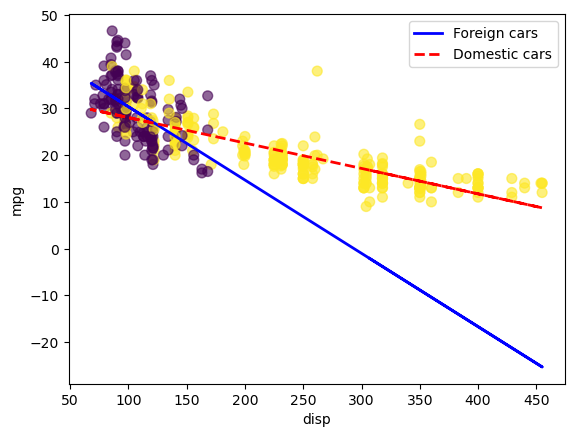

In [100]:
# Plotting
colors = autompg['domestic']
plt.scatter(autompg['disp'], autompg['mpg'], c=colors, marker='o', s=50, cmap='viridis', alpha=0.6)
plt.xlabel('disp')
plt.ylabel('mpg')

# Adding regression lines
x_vals = autompg['disp'].values
plt.plot(x_vals, int_for + slope_for * x_vals, color='blue', linewidth=2, label='Foreign cars')
plt.plot(x_vals, int_dom + slope_dom * x_vals, color='red', linestyle='--', linewidth=2, label='Domestic cars')

# Adding legend
plt.legend(loc='upper right')
plt.show()


Vemos que estas líneas se ajustan mucho mejor a los datos, lo que coincide con el resultado de nuestras pruebas.

Hasta ahora sólo hemos visto la interacción entre una variable categórica (`doméstica`) y una variable numérica (`disp`). Aunque esto es fácil de visualizar, ya que permite diferentes pendientes para dos líneas, no es el único tipo de interacción que podemos utilizar en un modelo. También podemos considerar interacciones entre dos variables numéricas.

Consideremos el modelo

$$
Y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_1 x_2 + \epsilon,
$$

donde

-   $Y$ es `mpg`,la eficiencia del combustible en millas por galón,
-   $x_1$ es `disp`, la cilindrada en pulgadas cúbicas,
-   $x_2$ es `hp`, la potencia, en pies-libra por segundo.

¿Cómo cambia `mpg` en función de `disp` en este modelo? Podemos reordenar algunos términos para ver cómo.

$$
Y = \beta_0 + (\beta_1 + \beta_3 x_2) x_1 + \beta_2 x_2 + \epsilon
$$

Así, para un aumento de una unidad en $x_1$ (`disp`), la media de $Y$ (`mpg`) aumenta $\beta_1 + \beta_3 x_2$, ¡que es un valor diferente dependiendo del valor de $x_2$ (`hp`)!

Como ahora trabajamos en tres dimensiones, este modelo no puede justificarse fácilmente mediante visualizaciones como el ejemplo anterior. En su lugar, tendremos que basarnos en una prueba.


In [101]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Fit the additive model
mpg_disp_add_hp = smf.ols(formula='mpg ~ disp + hp', data=autompg).fit()

# Fit the interaction model
mpg_disp_int_hp = smf.ols(formula='mpg ~ disp * hp', data=autompg).fit()

# Display the summary of the interaction model
print(mpg_disp_int_hp.summary())





                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     390.2
Date:                Tue, 19 Sep 2023   Prob (F-statistic):          1.73e-115
Time:                        21:35:42   Log-Likelihood:                -1062.4
No. Observations:                 383   AIC:                             2133.
Df Residuals:                     379   BIC:                             2148.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     52.4082      1.523     34.417      0.0


Usando `summary()` nos centramos en la fila para `disp:hp` que prueba,

$$
H_0: \beta_3 = 0.
$$

De nuevo, vemos un valor p muy bajo, por lo que rechazamos el nulo (modelo aditivo) a favor del modelo de interacción. De nuevo, existe una prueba $F$ equivalente.


In [102]:
# Conduct an ANOVA comparison between the two models
anova_results = sm.stats.anova_lm(mpg_disp_add_hp, mpg_disp_int_hp, typ=1)
print(anova_results)



   df_resid          ssr  df_diff      ss_diff           F        Pr(>F)
0     380.0  7576.553401      0.0          NaN         NaN           NaN
1     379.0  5754.231624      1.0  1822.321777  120.026443  1.887753e-24



Podemos examinar más detenidamente los coeficientes de nuestro modelo de interacción ajustado.


In [103]:

# Print the coefficients of the interaction model
print(mpg_disp_int_hp.params)

Intercept    52.408200
disp         -0.100174
hp           -0.219820
disp:hp       0.000566
dtype: float64



-   $\hat{\beta}_0 = 52.408$ es la media estimada de `mpg` para un coche con 0 `disp` y 0 `cv`.
-   $\hat{\beta}_1 = −0.100$ es el cambio estimado en la media de `mpg` para un aumento de 1 `disp`, **para un coche con 0 `hp`**.
-   $\hat{\beta}_2 = −0.219$ es el cambio estimado en la media de `mpg` para un aumento de 1 `hp`, **para un coche con 0 `disp`**.
-   $\hat{\beta}_3 = 5.66\times 10^{-4}$ es una estimación de la modificación del cambio en el promedio de `mpg` por un aumento en `disp`, para un coche de un determinado `hp` (o viceversa).

Este último coeficiente necesita más explicación. Recordemos la que hemos hecho antes

$$Y = \beta_0 + (\beta_1 + \beta_3 x_2) x_1 + \beta_2 x_2 + \epsilon.$$

Por lo tanto, nuestra estimación para $\beta_1 + \beta_3 x_2$, es
$\hat{\beta}_1 + \hat{\beta}_3 x_2$, que en este caso es

$$-0.1001738 + 5.658269\times 10^{-4} x_2.$$

Esto significa que, para un aumento de un `disp` vemos un cambio estimado en el `mpg` medio de $-0.1001738 + 5.658269\times 10^{-4} x_2$. Por tanto, la relación entre `disp` y `mpg` depende de los `cv` del coche.

Así que para un coche con 50 `hp`, el cambio estimado en promedio `mpg` para un aumento de un `disp` es

$$-0.1001738 + 5.658269\times 10^{-4} \cdot 50 = -0.0718824$$

Y para un coche con 350 `hp`, el cambio estimado en el promedio de `mpg` para un aumento de un `disp` es de

$$-0.1001738 + 5.658269\times 10^{-4} \cdot 350 = 0.0978657$$

¡Fíjate en que el signo ha cambiado!


## Variables categóricas

Hasta ahora  hemos limitado nuestro uso de variables categóricas a variables categóricas binarias. Específicamente, nos hemos limitado a variables ficticias que toman un valor de `0` o `1` y representan una variable categórica numéricamente.

Ahora hablaremos de las variables **categóricas**, con ellas, un usuario humano puede simplemente pensar en las categorías de una variable, y `Python` se encargará de las variables ficticias necesarias sin que el usuario tenga que hacer ninguna asignación 0/1.


In [104]:
# Check if column 'origin' is of factor type
print(autompg['origin'].dtype.name == 'category')

False



Antes, cuando utilizábamos la variable  `domestic`, no era una variable factorial. Era simplemente una variable numérica que sólo tenía dos valores posibles, `1` para nacional y  `0` para extranjero. Vamos a crear una nueva variable "origen" que almacena la misma información, pero de una manera diferente.

In [105]:
# Modify the 'origin' column based on the 'domestic' column values
autompg.loc[autompg['domestic'] == 1, 'origin'] = 'domestic'
autompg.loc[autompg['domestic'] == 0, 'origin'] = 'foreign'

# Display the head of the 'origin' column
print(autompg['origin'].head())

8 cylinder 70 chevrolet chevelle malibu    domestic
8 cylinder 70 buick skylark 320            domestic
8 cylinder 70 plymouth satellite           domestic
8 cylinder 70 amc rebel sst                domestic
8 cylinder 70 ford torino                  domestic
Name: origin, dtype: object


In [106]:
# Convert 'origin' column to factor type
autompg['origin'] = autompg['origin'].astype('category')



Ahora la variable `origin` almacena `"domestic"` para carros nacionales y `"foreign"` para los carros extranjeros.


In [107]:
# Check if column 'origin' is of factor type
print(autompg['origin'].dtype.name == 'category')

True



Observe que python se ha encargado de crear las categorias correspondientes. 


In [108]:
# Print the levels (unique values) of 'origin'
print(autompg['origin'].cat.categories)

Index(['domestic', 'foreign'], dtype='object')



``` {r}
autompg$origin = as.factor(autompg$origin)
```



Ahora, cuando comprobamos la estructura del conjunto de datos `autompg`, vemos que `origin` es una variable categórica.

In [109]:
# Print the structure (info) of the DataFrame
print(autompg.info())

<class 'pandas.core.frame.DataFrame'>
Index: 383 entries, 8 cylinder 70 chevrolet chevelle malibu to 4 cylinder 82 chevy s-10
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   mpg       383 non-null    float64 
 1   cyl       383 non-null    category
 2   disp      383 non-null    float64 
 3   hp        383 non-null    float64 
 4   wt        383 non-null    float64 
 5   acc       383 non-null    float64 
 6   year      383 non-null    int64   
 7   origin    383 non-null    category
 8   domestic  383 non-null    int32   
 9   x3        383 non-null    float64 
dtypes: category(2), float64(6), int32(1), int64(1)
memory usage: 34.5+ KB
None



Las variables categóricas tienen **niveles** que son los posibles valores (categorías) que puede tomar la variable, en este caso extranjera o nacional.


In [110]:
# Print the levels (unique values) of 'origin'
print(autompg['origin'].cat.categories)

Index(['domestic', 'foreign'], dtype='object')



Recordemos que anteriormente hemos ajustado el modelo

$$ Y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_1 x_2 + \epsilon, $$

donde

-   $Y$ es `mpg`, la eficiencia del combustible en millas por galón,
-   $x_1$ es `disp`, la cilindrada en pulgadas cúbicas,
-   $x_2$ es `domestic`,una variable ficticia en la que `1` indica un coche nacional.


In [111]:
# Fit the model with interaction between disp and domestic
mod_dummy = smf.ols(formula='mpg ~ disp * domestic', data=autompg).fit()
mod_dummy.params


Intercept        46.054842
disp             -0.156924
domestic        -12.575471
disp:domestic     0.102518
dtype: float64


Así que aquí vemos que

$$\hat{\beta}_0 + \hat{\beta}_2 = 46.0548423 + -12.5754714 = 33.4793709$$

es la media estimada de `mpg` para un coche **doméstico** con 0 `disp`.

Ahora intentemos hacer lo mismo, pero utilizando nuestra nueva variable factorial.


In [112]:
# Fit the model with interaction between disp and origin
mod_factor = smf.ols(formula='mpg ~ disp * origin', data=autompg).fit()
mod_factor.params

Intercept                 33.479371
origin[T.foreign]         12.575471
disp                      -0.054405
disp:origin[T.foreign]    -0.102518
dtype: float64


Parece que no produce los mismos resultados. Enseguida nos damos cuenta de que el intercepto es diferente, al igual que el coeficiente que precede a `disp`. También observamos que los dos coeficientes restantes son de la misma magnitud que sus homólogos respectivos utilizando la variable nacional, pero con un signo diferente. ¿Por qué ocurre esto?

Resulta que al utilizar una variable factorial, `R` nos crea automáticamente una variable ficticia. Sin embargo, no es la variable ficticia que habíamos utilizado originalmente.

`R` está ajustando el modelo

$$Y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_1 x_2 + \epsilon,$$

donde

- $Y$ es `mpg`, la eficiencia del combustible en millas por galón,
- $x_1$ es `disp`, el desplazamiento en pulgadas cúbicas,
- $x_2$ **es una variable ficticia creada por `Python`.** Utiliza `1` para representar un **carro extranjero**.

Así que ahora,

$$\hat{\beta}_0 = 33.4793709$$

es la media estimada de "mpg" de un coche "nacional" con 0 "disp", que es la misma que antes.

Cuando `Python` creó $x_2$, la variable ficticia, utilizó los carros nacionales como el nivel de **referencia**, que es el valor por defecto de la variable categórica. Así que cuando la variable ficticia es "0", el modelo representa este nivel de referencia, que es nacional. (`Python` hace esta elección porque nacional va antes que extranjero alfabéticamente, ojo mirando las palabras en ingles claro está).

Así pues, los dos modelos tienen coeficientes estimados diferentes, pero debido a las distintas representaciones del modelo, en realidad son el mismo modelo.



### Factores con más de dos niveles

Consideremos ahora una variable factorial con más de dos niveles. En este conjunto de datos, `cyl` es un ejemplo.


In [113]:
# Check if column 'cyl' is of factor type
print(autompg['cyl'].dtype.name == 'category')

True


In [114]:
# Print the levels (unique values) of 'cyl'
print(autompg['cyl'].cat.categories)

Int64Index([4, 6, 8], dtype='int64')




Aquí la variable `cyl` tiene tres niveles posibles: `4`, `6` y `8`. Te preguntarás, ¿por qué no utilizar simplemente `cyl` como una variable numérica? Por supuesto que podría.

Sin embargo, eso forzaría a que la diferencia en mpg medio entre `4` y `6` cilindros fuera la misma que la diferencia en mpg medio entre `6` y `8` cilindros. Esto suele tener sentido para una variable continua, pero no para una variable discreta con tan pocos valores posibles. En el caso de esta variable, no existe un motor de 7 cilindros ni un motor de 6,23 cilindros en vehículos personales. Por estas razones, consideraremos simplemente que `cyl` es categórica. Se trata de una decisión que normalmente habrá que tomar con variables ordinales. A menudo, con un gran número de categorías, la decisión de tratarlas como variables numéricas es apropiada porque, de lo contrario, se necesitaría un gran número de variables ficticias para representar estas variables.

Definamos tres variables ficticias relacionadas con la variable factorial `cyl`.

$$
v_1 =
  \begin{cases}
   1 & \text{4 cylinder} \\
   0       & \text{not 4 cylinder}
  \end{cases}
$$

$$
v_2 =
  \begin{cases}
   1 & \text{6 cylinder} \\
   0       & \text{not 6 cylinder}
  \end{cases}
$$

$$
v_3 =
  \begin{cases}
   1 & \text{8 cylinder} \\
   0       & \text{not 8 cylinder}
  \end{cases}
$$



Ahora, vamos a ajustar un modelo aditivo en `Python`, utilizando `mpg` como respuesta, y `disp` y `cyl` como predictores. Esto debería ser un modelo que utiliza "tres líneas de regresión" para modelar `mpg`, uno para cada uno de los posibles niveles de `cyl`. Todos ellos tendrán la misma pendiente (ya que es un modelo aditivo), pero cada uno tendrá su propio intercepto.

In [115]:
# Fit the additive model with disp and cyl
mpg_disp_add_cyl = smf.ols(formula='mpg ~ disp + C(cyl)', data=autompg).fit()
print(mpg_disp_add_cyl.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     280.8
Date:                Tue, 19 Sep 2023   Prob (F-statistic):           6.24e-96
Time:                        21:35:42   Log-Likelihood:                -1107.9
No. Observations:                 383   AIC:                             2224.
Df Residuals:                     379   BIC:                             2240.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      34.9993      0.822     42.561      


La pregunta es, ¿cuál es el modelo que `Python` ha ajustado aquí? Ha elegido utilizar el modelo

$$Y = \beta_0 + \beta_1 x + \beta_2 v_2 + \beta_3 v_3 + \epsilon,$$

donde

- $Y$ es `mpg`, la eficiencia del combustible en millas por galón,
- $x$ es `disp`, el desplazamiento en pulgadas cúbicas,
- $v_2$ y $v_3$ son las variables ficticias definidas anteriormente.

¿Por qué `R` no utiliza $v_1$? Básicamente porque no es necesario. Para crear tres líneas, sólo necesita dos variables ficticias, ya que está utilizando un nivel de referencia, que en este caso es un coche de 4 cilindros. Los tres "submodelos" son entonces:

-   4 Cilindro: $Y = \beta_0 + \beta_1 x + \epsilon$
-   6 Cilindro: $Y = (\beta_0 + \beta_2) + \beta_1 x + \epsilon$
-   8 Cilindro: $Y = (\beta_0 + \beta_3) + \beta_1 x + \epsilon$

Obsérvese que todos tienen la misma pendiente. Sin embargo, utilizando las dos variables ficticias obtenemos los tres interceptos.

- $\beta_0$ es el promedio de `mpg` para un coche de 4 cilindros con 0 `disp`.
- $\beta_0 + \beta_2$ es la media de "mpg" de un coche de 6 cilindros con 0
    disp`.
- $\beta_0 + \beta_3$ es la media de `mpg` de un coche de 8 cilindros con 0
    `disp`.

Como el nivel de referencia es el de 4 cilindros, $\beta_0$ es específico de 4 cilindros, pero $\beta_2$ y $\beta_3$ se utilizan para representar cantidades relativas a 4 cilindros.

Como hemos hecho antes, podemos extraer estos interceptos y pendientes para las tres rectas, y trazarlos en consecuencia.

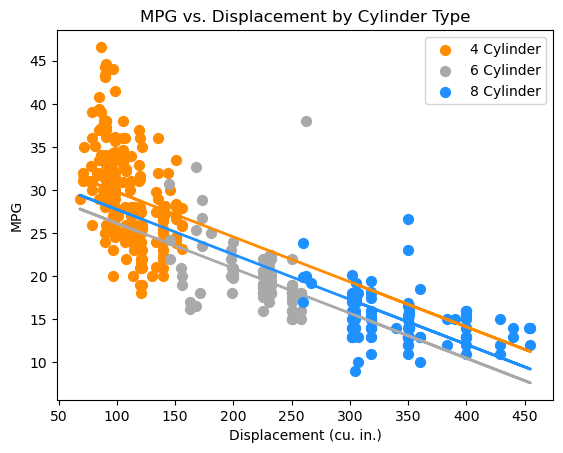

In [116]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf  # use smf instead of sm for formula API
import matplotlib.pyplot as plt

# Ensure the 'cyl' column is a categorical column
autompg['cyl'] = autompg['cyl'].astype('category')

# Create a linear model object
mpg_disp_add_cyl = smf.ols("mpg ~ disp + C(cyl)", data=autompg).fit()

# Get the intercept and slope coefficients for each cylinder type
int_4cyl = mpg_disp_add_cyl.params['Intercept']
slope_4cyl = mpg_disp_add_cyl.params['disp']

# 6 and 8 cylinders' intercepts will be the sum of the main intercept and their respective coefficients
int_6cyl = int_4cyl + mpg_disp_add_cyl.params['C(cyl)[T.6]']
int_8cyl = int_4cyl + mpg_disp_add_cyl.params['C(cyl)[T.8]']

# Slopes for 6 and 8 cylinders remain the same as 4 cylinder's slope
slope_6cyl = slope_4cyl
slope_8cyl = slope_4cyl

# Create a plot of mpg vs. disp, colored by cylinder type
plot_colors = ["Darkorange", "Darkgrey", "Dodgerblue"]
plt.figure()

# Scatter plots for each cylinder type
for cyl, color in zip([4, 6, 8], plot_colors):
    plt.scatter(autompg[autompg['cyl'] == cyl]["disp"], 
                autompg[autompg['cyl'] == cyl]["mpg"], 
                c=color, s=50, label=f"{cyl} Cylinder")

# Add a regression line for each cylinder type
plt.plot(autompg["disp"], int_4cyl + slope_4cyl * autompg["disp"], c=plot_colors[0], lw=2)
plt.plot(autompg["disp"], int_6cyl + slope_6cyl * autompg["disp"], c=plot_colors[1], lw=2)
plt.plot(autompg["disp"], int_8cyl + slope_8cyl * autompg["disp"], c=plot_colors[2], lw=2)

# Add a legend
plt.legend()

# Set the plot title and labels
plt.title("MPG vs. Displacement by Cylinder Type")
plt.xlabel("Displacement (cu. in.)")
plt.ylabel("MPG")

# Show the plot
plt.show()



En este gráfico, tenemos

- 4 Cilindro: puntos naranjas, línea naranja continua.
- 6 Cilindro: puntos grises, línea  gris continua.
- 8 cilindros: puntos azules, línea azul continua.

El extraño resultado aquí es que estamos estimando que los carros de 8 cilindros tienen mejor eficiencia de combustible que los de 6 cilindros en **cualquier** cilindrada. La línea azul  está siempre por encima de la línea gris discontinua. No parece correcto. Quizás para motores de gran cilindrada podría ser cierto, pero parece erróneo para cilindradas medias y bajas.

Para intentar arreglar esto, intentaremos usar un modelo de interacción, es decir, en lugar de simplemente tres interceptos y una pendiente, permitiremos tres pendientes. Una vez más, dejaremos que `Python` haga su trabajo, y luego averiguaremos qué modelo ha aplicado.


In [117]:
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf

# Fit the model with an interaction term
mpg_disp_int_cyl = smf.ols('mpg ~ disp * cyl', data=autompg).fit()
print(mpg_disp_int_cyl.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     195.4
Date:                Tue, 19 Sep 2023   Prob (F-statistic):          2.66e-102
Time:                        21:35:42   Log-Likelihood:                -1087.2
No. Observations:                 383   AIC:                             2186.
Df Residuals:                     377   BIC:                             2210.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        43.5905      1.556     28.015


Python ha vuelto a elegir los carros de 4 cilindros como nivel de referencia, pero esto también afecta a los términos de interacción. `python` ha ajustado el modelo.

$$Y = \beta_0 + \beta_1 x + \beta_2 v_2 + \beta_3 v_3 + \gamma_2 x v_2 + \gamma_3 x v_3 + \epsilon$$

Estamos utilizando $\gamma$ como un parámetro $\beta$ para simplificar, de modo que, por ejemplo $\beta_2$ y $\gamma_2$ son ambos asociados con $v_2$.

Ahora, los tres "submodelos" son:

-   4 Cilindro: $Y = \beta_0 + \beta_1 x + \epsilon$.
-   6 Cilindro::
    $Y = (\beta_0 + \beta_2) + (\beta_1 + \gamma_2) x + \epsilon$.
-   8 Cilindro:
    $Y = (\beta_0 + \beta_3) + (\beta_1 + \gamma_3) x + \epsilon$.

Interpretando algunos parámetros y coeficientes entonces:

- $(\beta_0 + \beta_2)$ es el promedio de `mpg` de un coche de 6 cilindros con
    0 `disp`
-   $(\hat{\beta}_1 + \hat{\gamma}_3) = -0.1306935 + 0.1081714 = -0.0225221$
    es el cambio estimado en el promedio de "mpg" para un aumento de un  `disp` , para un coche de 8 cilindros.

Así que, como hemos visto antes, $\beta_2$ y $\beta_3$ cambian los interceptos para carros de 6 y 8 cilindros en relación con el nivel de referencia de $\beta_0$ para carros de 4 cilindros.

Ahora, de forma similar, $\gamma_2$ y $\gamma_3$ cambian las pendientes de los carros de 6 y 8 cilindros en relación con el nivel de referencia de $\beta_1$ para los carros de 4 cilindros.

Una vez más, extraemos los coeficientes y trazamos los resultados.


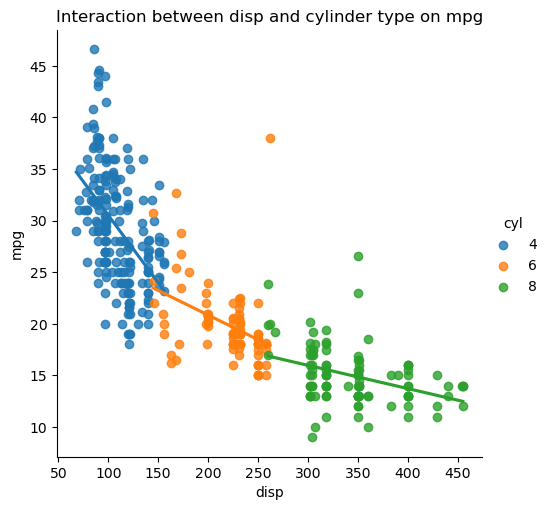

In [118]:
# Interaction plot
sns.lmplot(data=autompg, x='disp', y='mpg', hue='cyl', ci=None)
plt.title('Interaction between disp and cylinder type on mpg')
plt.show()


Esto tiene mucho mejor aspecto. Podemos ver que, en el caso de los carros de cilindrada media, los carros de 6 cilindros obtienen ahora mejores resultados que los de 8 cilindros, lo que parece mucho más razonable que antes.

Para justificar completamente el modelo de interacción (es decir, una pendiente única para cada nivel de `cyl`) en comparación con el modelo aditivo (pendiente única), podemos realizar una prueba $F$. Observe primero que no hay ninguna prueba $t$ que pueda hacer esto, ya que la diferencia entre los dos modelos no es un único parámetro.

Haremos la prueba,

$H_0: \gamma_2 = \gamma_3 = 0$

que representa las líneas de regresión paralelas que vimos antes,

$$Y = \beta_0 + \beta_1 x + \beta_2 v_2 + \beta_3 v_3 + \epsilon.$$

De nuevo, se trata de una diferencia de dos parámetros, por lo que no será útil ninguna prueba $t$.


In [119]:
# Now, use anova_lm to compare
table = sm.stats.anova_lm(mpg_disp_add_cyl, mpg_disp_int_cyl, typ=1)
print(table)

   df_resid          ssr  df_diff     ss_diff          F        Pr(>F)
0     379.0  7299.524999      0.0         NaN        NaN           NaN
1     377.0  6551.731850      2.0  747.793149  21.514771  1.419369e-09



Como era de esperar, vemos un valor p muy bajo y, por tanto, rechazamos la nulidad. Preferimos el modelo de interacción al modelo aditivo.

Recapitulando un poco:

-   Modelo Nulo
    $Y = \beta_0 + \beta_1 x + \beta_2 v_2 + \beta_3 v_3 + \epsilon$
    -   Número de parámetros: $q = 4$
-   Modelo completo:
    $Y = \beta_0 + \beta_1 x + \beta_2 v_2 + \beta_3 v_3 + \gamma_2 x v_2 + \gamma_3 x v_3 + \epsilon$
    -   Número de parámetros: $p = 6$


In [120]:
difference = len(mpg_disp_int_cyl.params) - len(mpg_disp_add_cyl.params)
print(difference)


2


Vemos que hay una diferencia de dos parámetros, que también aparece en la tabla ANOVA resultante de `R`. Observe que los dos valores siguientes también aparecen en la tabla ANOVA.



## Parametrización

Hasta ahora hemos dejado que `Python` decida cómo crear las variables ficticias y, por lo tanto, `Python` ha decidido la parametrización de los modelos. Para ilustrar la capacidad de utilizar parametrizaciones alternativas, vamos a recrear los datos, pero creando directamente las variables ficticias nosotros mismos.

In [121]:
# Creating new dataframe
autompg['v1'] = (autompg['cyl'] == 4).astype(int)
autompg['v2'] = (autompg['cyl'] == 6).astype(int)
autompg['v3'] = (autompg['cyl'] == 8).astype(int)
new_param_data = autompg[['mpg', 'disp', 'v1', 'v2', 'v3']]

print(new_param_data.head(20))

                                             mpg   disp  v1  v2  v3
8 cylinder 70 chevrolet chevelle malibu     18.0  307.0   0   0   1
8 cylinder 70 buick skylark 320             15.0  350.0   0   0   1
8 cylinder 70 plymouth satellite            18.0  318.0   0   0   1
8 cylinder 70 amc rebel sst                 16.0  304.0   0   0   1
8 cylinder 70 ford torino                   17.0  302.0   0   0   1
8 cylinder 70 ford galaxie 500              15.0  429.0   0   0   1
8 cylinder 70 chevrolet impala              14.0  454.0   0   0   1
8 cylinder 70 plymouth fury iii             14.0  440.0   0   0   1
8 cylinder 70 pontiac catalina              14.0  455.0   0   0   1
8 cylinder 70 amc ambassador dpl            15.0  390.0   0   0   1
8 cylinder 70 dodge challenger se           15.0  383.0   0   0   1
8 cylinder 70 plymouth 'cuda 340            14.0  340.0   0   0   1
8 cylinder 70 chevrolet monte carlo         15.0  400.0   0   0   1
8 cylinder 70 buick estate wagon (sw)       14.0


Ahora,

- `y`es `mpg`
- `x` es `disp`, el desplazamiento en pulgadas cúbicas,
- `v1`, `v2`, y `v3` son variables ficticias como se definieron anteriormente.

En primer lugar vamos a tratar de ajustar un modelo aditivo utilizando `x`, en este caso somos nosotros quienes definimos cual es la variable de referencia.

In [122]:
# Linear models
model1 = smf.ols('mpg ~ disp + v1 + v2 ', data=new_param_data).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     280.8
Date:                Tue, 19 Sep 2023   Prob (F-statistic):           6.24e-96
Time:                        21:35:46   Log-Likelihood:                -1107.9
No. Observations:                 383   AIC:                             2224.
Df Residuals:                     379   BIC:                             2240.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     32.9633      2.437     13.527      0.0

 Esto se debe a que

$$\boldsymbol{1} = v_1 + v_2 + v_3$$

lo que significa que $\boldsymbol{1}$, $v_1$, $v_2$, y $v_3$ son linealmente dependientes. Esto haría que la matriz $X^\top X$ fuera singular, pero tenemos que ser capaces de invertirlo para resolver las ecuaciones normales y obtener $\hat{\beta}.$ Con el intercepto, `v1`, y `v2`, `Python` puede hacer los necesarios "tres interceptos". Por lo tanto, en este caso `v3` es el nivel de referencia.

Si eliminamos el intercepto, entonces podemos obtener directamente los "tres interceptos" sin un nivel de referencia.

In [202]:
model2 = smf.ols('mpg ~ 0 + disp + v1 + v2 + v3', data=new_param_data).fit()
print(model2.summary())


                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     280.8
Date:                Mon, 18 Sep 2023   Prob (F-statistic):           6.28e-96
Time:                        12:43:17   Log-Likelihood:                -1107.9
No. Observations:                 383   AIC:                             2224.
Df Residuals:                     379   BIC:                             2240.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
disp          -0.0522      0.007     -7.504      0.0


Aquí, estamos ajustando el modelo

$$
Y = \mu_1 v_1 + \mu_2 v_2 + \mu_3 v_3 + \beta x +\epsilon.
$$

Así tenemos:

-   4 Cilindro: $Y = \mu_1 + \beta x + \epsilon$
-   6 Cilindro: $Y = \mu_2 + \beta x + \epsilon$
-   8 Cilindro: $Y = \mu_3 + \beta x + \epsilon$

También podríamos hacer algo parecido con el modelo de interacción, y dar a cada línea una intercepción y una pendiente, sin necesidad de un nivel de referencia.


In [203]:
model3 = smf.ols('mpg ~ 0 + v1 + v2 + v3 + disp:v1 + disp:v2 + disp:v3', data=new_param_data).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     195.3
Date:                Mon, 18 Sep 2023   Prob (F-statistic):          2.72e-102
Time:                        12:44:24   Log-Likelihood:                -1087.2
No. Observations:                 383   AIC:                             2186.
Df Residuals:                     377   BIC:                             2210.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
v1            43.5856      1.556     28.013      0.0

$$ Y = \mu_1 v_1 + \mu_2 v_2 + \mu_3 v_3 + \beta x +\epsilon.$$

-   4 Cilindro: $Y = \mu_1 + \beta_1 x + \epsilon$
-   6 Cilindro: $Y = \mu_2 + \beta_2 x + \epsilon$
-   8 Cilindro: $Y = \mu_3 + \beta_3 x + \epsilon$

Utilizando los datos originales, tenemos (al menos) tres formas equivalentes de especificar el modelo de interacción con `Python`.


In [204]:
model4 = smf.ols('mpg ~ disp * cyl', data=autompg).fit()
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     195.3
Date:                Mon, 18 Sep 2023   Prob (F-statistic):          2.72e-102
Time:                        12:45:15   Log-Likelihood:                -1087.2
No. Observations:                 383   AIC:                             2186.
Df Residuals:                     377   BIC:                             2210.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        43.5856      1.556     28.013

In [205]:
model5 = smf.ols('mpg ~ 0 + cyl + disp:cyl', data=autompg).fit()
print(model5.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     195.3
Date:                Mon, 18 Sep 2023   Prob (F-statistic):          2.72e-102
Time:                        12:46:03   Log-Likelihood:                -1087.2
No. Observations:                 383   AIC:                             2186.
Df Residuals:                     377   BIC:                             2210.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
cyl[4]         43.5856      1.556     28.013      

In [206]:
model6 = smf.ols('mpg ~ 0 + disp + cyl + disp:cyl', data=autompg).fit()
print(model6.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     195.3
Date:                Mon, 18 Sep 2023   Prob (F-statistic):          2.72e-102
Time:                        12:46:15   Log-Likelihood:                -1087.2
No. Observations:                 383   AIC:                             2186.
Df Residuals:                     377   BIC:                             2210.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
cyl[4]           43.5856      1.556     28.013


Todos se ajustan al mismo modelo, cada uno con seis parámetros, pero los coeficientes significan cosas ligeramente diferentes en cada uno. Sin embargo, una vez interpretados como pendientes e interceptos para las "tres líneas", tendrán el mismo resultado.






## Creación de modelos más amplios

Ahora que hemos visto cómo incorporar predictores categóricos así como términos de interacción, podemos empezar a construir modelos mucho más grandes y flexibles que potencialmente pueden ajustarse mejor a los datos.

Definamos un modelo "grande",

$$Y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \beta_4 x_1 x_2 + \beta_5 x_1 x_3 + \beta_6 x_2 x_3 + \beta_7 x_1 x_2 x_3 + \epsilon.$$

Aquí,

-   $Y$ es `mpg`.
-   $x_1$ es `disp`.
-   $x_2$ es `hp`.
-   $x_3$ es `domestic`, que es una variable ficticia que definimos, donde `1` es un vehículo nacional.

En primer lugar, hemos incluido un nuevo término $x_1 x_2 x_3$ que es una interacción de tres vías. Los términos de interacción pueden ser cada vez mayores, hasta el número de predictores del modelo.

Dado que estamos utilizando el término de interacción de tres vías, también utilizamos todas las posibles interacciones de dos vías, así como cada uno de los términos de primer orden (**efecto principal**). Este es el concepto de **jerarquía**. Cada vez que un término de "orden superior" está en un modelo, los términos de "orden inferior" relacionados también deben incluirse. Matemáticamente, su inclusión o exclusión es a veces irrelevante, pero desde el punto de vista de la interpretación, es mejor seguir las reglas de la jerarquía.

Hagamos algunos reordenamientos para obtener un "coeficiente" delante de $x_1$.

$$Y = \beta_0 + \beta_2 x_2 + \beta_3 x_3 + \beta_6 x_2 x_3 + (\beta_1 + \beta_4 x_2 + \beta_5 x_3 + \beta_7 x_2 x_3)x_1 + \epsilon.$$

En concreto, el "coeficiente" delante de $x_1$ es

$$(\beta_1 + \beta_4 x_2 + \beta_5 x_3 + \beta_7 x_2 x_3).$$

Hablemos de este "coeficiente" para ayudarnos a comprender la idea de la *flexibilidad* de un modelo. Recordemos que

- $\beta_1$ es el coeficiente de un término de primer orden,
- $\beta_4$ y $\beta_5$ son coeficientes para interacciones bidireccionales,
- $\beta_7$ es el coeficiente para la interacción de tres vías.

Si las interacciones de dos y tres vías no estuvieran en el modelo, el "coeficiente" completo sería simplemente

$$\beta_1.$$

Así, independientemente de los valores de $x_2$ y $x_3$, $\beta_1$ determinaría la relación entre $x_1$ (`disp`) y $Y$ (`mpg`).

Con la adición de las interacciones bidireccionales, ahora el "coeficiente" sería

$$(\beta_1 + \beta_4 x_2 + \beta_5 x_3).$$

Ahora, cambiar $x_1$ (`disp`) tiene un efecto diferente en $Y$ (`mpg`), dependiendo de los valores de $x_2$ y $x_3$.

Por último, añadiendo la interacción de tres vías se obtiene el "coeficiente" completo

$$(\beta_1 + \beta_4 x_2 + \beta_5 x_3 + \beta_7 x_2 x_3)$$

que es aún más flexible. Ahora cambiar $x_1$ (`disp`) tiene un efecto diferente en $Y$ (`mpg`), dependiendo de los valores de $x_2$ y $x_3$, pero de una manera más flexible que podemos ver con un poco más de reordenación. Ahora el "coeficiente" delante de $x_3$ en este "coeficiente" es depende de $x_2$.

$$(\beta_1 + \beta_4 x_2 + (\beta_5 + \beta_7 x_2) x_3)$$

Es tan flexible que resulta difícil de interpretar.

Vamos a ajustar este modelo de interacción de tres vías en `Python`.


In [208]:
big_model = smf.ols('mpg ~ disp * hp * domestic', data=autompg).fit()
print(big_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     169.7
Date:                Mon, 18 Sep 2023   Prob (F-statistic):          4.53e-112
Time:                        12:47:33   Log-Likelihood:                -1058.7
No. Observations:                 383   AIC:                             2133.
Df Residuals:                     375   BIC:                             2165.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           60.6458      6.600  


¿Necesitamos un modelo tan grande? Probemos primero la necesidad del término de interacción de tres vías. Es decir,


$$H_0: \beta_7 = 0.$$

Entonces,

-   Modelo completo:
    $Y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \beta_4 x_1 x_2 + \beta_5 x_1 x_3 + \beta_6 x_2 x_3 + \beta_7 x_1 x_2 x_3 + \epsilon$
-   Modelo nulo:
    $Y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \beta_4 x_1 x_2 + \beta_5 x_1 x_3 + \beta_6 x_2 x_3 + \epsilon$

Ajustamos el modelo nulo en `Python` como `two_way_int_mod`, luego usamos `anova_lm()` para realizar una prueba $F$ como de costumbre.


In [209]:
two_way_int_mod = smf.ols('mpg ~ disp * hp + disp * domestic + hp * domestic', data=autompg).fit()

print(two_way_int_mod.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     197.2
Date:                Mon, 18 Sep 2023   Prob (F-statistic):          7.68e-113
Time:                        12:47:55   Log-Likelihood:                -1059.6
No. Observations:                 383   AIC:                             2133.
Df Residuals:                     376   BIC:                             2161.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        52.0420      1.786     29.134

In [210]:
# ANOVA comparison
print(sm.stats.anova_lm(two_way_int_mod, big_model, typ=1))


   df_resid         ssr  df_diff   ss_diff         F    Pr(>F)
0     376.0  5673.45199      0.0       NaN       NaN       NaN
1     375.0  5645.85155      1.0  27.60044  1.833234  0.176561



Vemos que el valor p es algo grande, por lo que no lo rechazaríamos. Preferimos el modelo nulo, más pequeño y menos flexible, sin la interacción de tres vías.

Una nota rápida aquí: el modelo completo sigue "ajustándose mejor". Observe que tiene un RMSE menor que el modelo nulo, lo que significa que el modelo completo comete errores (al cuadrado) menores de media.

In [211]:
print((big_model.resid ** 2).mean())

print((two_way_int_mod.resid ** 2).mean())

14.741126762831584
14.813190574889921



Sin embargo, no es mucho menor. Incluso podríamos decir que la diferencia es insignificante. Esta es una idea sobre la que volveremos más adelante con más detalle.

Ahora que hemos elegido el modelo sin la interacción de tres vías, ¿podemos ir más allá? ¿Necesitamos las interacciones bidireccionales? Probemos

$$H_0: \beta_4 = \beta_5 = \beta_6 = 0.$$

Recuerda que ya elegimos $\beta_7 = 0$, entonces,

-   Modelo completo
    $Y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \beta_4 x_1 x_2 + \beta_5 x_1 x_3 + \beta_6 x_2 x_3 + \epsilon$
-   Modelo nulo
    $Y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \epsilon$

Ajustamos el modelo nulo en `Python` como `additive_mod`, luego usamos `anova_lm()` para


realizar una prueba $F$ como de costumbre.


In [212]:

additive_mod = smf.ols('mpg ~ disp + hp + domestic', data=autompg).fit()

print(sm.stats.anova_lm(additive_mod, two_way_int_mod, typ=1))

   df_resid          ssr  df_diff      ss_diff          F        Pr(>F)
0     379.0  7369.773479      0.0          NaN        NaN           NaN
1     376.0  5673.451990      3.0  1696.321489  37.473769  3.289643e-21



Aquí el valor p es pequeño, por lo que rechazamos el nulo y preferimos el modelo completo (alternativo). De los modelos que hemos considerado, nuestra preferencia final es para

$$Y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \beta_4 x_1 x_2 + \beta_5 x_1 x_3 + \beta_6 x_2 x_3 + \epsilon.$$

